# Knapsack problem
Here we shall summarize the following ways to solve a given knapsack problem
1. classical dynamical programming method
2. simulated annealing method from dwave
3. annealing method on dwave device
4. canonical qaoa method
5. simulated adiabatic quantum computation
6. simulated adiabatic quantum computation with penalty dephasing
7. simulated adiabatic quantum computation with zeno

# Import

In [672]:
# For annealing in dwave
from dimod import SimulatedAnnealingSampler, BinaryQuadraticModel, BINARY
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

# For qaoa in qiskit
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.circuit import Parameter, Gate
from qiskit.compiler import transpile

import numpy as np
pi = np.pi
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from typing import List, Union




# Define the problem

The knapsack problem can be summarized as following. Let $x_i$ be binary variables ($x_i=0,1$), we aim to 

\begin{align}
\text{max}\sum_iv_ix_i, \quad \text{subject to }\quad \sum_iw_ix_i\leq W
\end{align}
Upon introducing slack variable, the problem is equivalent to minimize the following cost function 
\begin{align}
f = -\sum_iv_ix_i + P(\sum_iw_ix_i + \sum_k2^kc_k - W)^2
\end{align}
where $P$ is the Lagrange multiplier.

In [138]:
v = [5,6,7,8,9] 
w = [4,5,6,7,8]
W = int(0.6 * sum(w))

# Method 1: dynamical programming

In [139]:
def dp(W, wt, val):
    """Solve the Knapsack problem with dynamical programming
    
    Args:
        W: The limit of the total weights of the chosen items
        wt: The weigths of the items
        val: The values of the items
        
    """
    n = len(val)
    k = [[0 for x in range(W + 1)] for x in range(n + 1)]
    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                k[i][w] = 0
            elif wt[i-1] <= w:
                k[i][w] = max(val[i-1] + k[i-1][w-wt[i-1]], k[i-1][w])
            else:
                k[i][w] = k[i-1][w]
                
    picks=[0 for x in range(n)]
    volume=W
    for i in range(n,-1,-1):
        if (k[i][volume]>k[i-1][volume]):
            picks[i-1]=1
            volume -= wt[i-1]
    return k[n][W], picks

In [140]:
print("optimal value:", dp(W, w, v)[0])
print('\n index of the chosen items:')
for i in range(len(val)): 
    if dp(W, w, v)[1][i]: 
        print(i,end=' ')

optimal value: 21

 index of the chosen items:
1 2 3 

# Method 2: Simulated annealing
The typical QUBO takes the following form

$
f({\bf x}) = {\bf x}^TQ{\bf x} + {\bf B}{\bf x}^T
$

where ${\bf x}$ is a $n\times 1$ vector of binary variables ($x_i=0,1$), and $Q$ is a $n\times n$ real symmetric matrix, and $B$ is a $1\times n$ real vector. 

To convert $f(x)$ to the Ising Hamiltonian, we perform the mapping (we adopt Dwave's convention here)

$
x_i\rightarrow \frac{1}{2}(\mathbb{I}+Z)_i,\quad i=1,...,n
$

for each binary variable. To understand this probably, let us consider a simple example. Suppose, we have ${\bf x}=(x_1,x_2,x_3)^T$, then we have

$
x_1\rightarrow \frac{\mathbb{I}+Z}{2}\otimes\mathbb{I}\otimes\mathbb{I}, \quad
x_2\rightarrow \mathbb{I}\otimes\frac{\mathbb{I}+Z}{2}\otimes\mathbb{I}, \quad
x_3\rightarrow \mathbb{I}\otimes\mathbb{I}\otimes\frac{\mathbb{I}+Z}{2}
$

In other word, each $x_i$ is represented by a tensor product of $n$ identity matrices, with the $i$-th one replaced by $(\mathbb{I}+Z)/2$. More generally, we use $U_i$ to denote a tensor product of $n$ identity matrices with the $i$-th one replaced by the matrix $U$. With these, we have

\begin{align}
&f({\bf x}) =\sum_{ij}x_iQ_{ij}x_j + \sum_iB_ix_i\\
\rightarrow&H_c= \sum_{ij}Q_{ij}\frac{(\mathbb{I}+Z)_i}{2}\frac{(\mathbb{I}+Z)_j}{2} + \sum_iB_i\frac{(\mathbb{I}+Z)_i}{2} \\
&\quad=\sum_{ij}\frac{1}{4}Q_{ij}Z_iZ_j + \frac{1}{2}\sum_i\left(\sum_jQ_{ij}+B_i\right)Z_i + \left(\frac{1}{4}\sum_{ij}Q_{ij}+\frac{1}{2}\sum_iB_i\right)\mathbb{I}\\
&\quad=\sum_{i<j}\frac{1}{2}Q_{ij}Z_iZ_j + \frac{1}{2}\sum_i\left(\sum_jQ_{ij}+B_i\right)Z_i + \left(\frac{1}{4}\sum_{ij}Q_{ij}+\frac{1}{2}\sum_iB_i+\frac{1}{4}\sum_iQ_{ii}\right)\mathbb{I}\\
\end{align}
where in the first term we have made use of the fact that $Q_{ij}$ is symmetric, and $Z_i$ commutes with $Z_j$.
Since the last term is a constant term, with no effect on the eigenstates, we shall ignore it. We are interested in constructing a quantum circuit corresponding to 

Let us first obtain the ${\bf Q}, B$ matrices for the knapsack problem

In [481]:
def get_Q_B(W, w, v, P=None):
    """Reformulate the knapsack problem to QUBO specified by Q, B
    
    
    Args:
        W: The limit of the total weights of the chosen items
        w: The weigths of the items
        v: The values of the items
        P: Penalty weight
    """
    
    n = len(v) # number of items
    num_slack = int(np.ceil(np.log2(W))) + 1
    
    if P is None:
        # The default penalty weight is 10 times the max bias.
        P = 10 * max(max(v), -min(v)) 
        print(f"The chosen penalty weight = {P}")
    
    Q = {}
    B = {}

    def add_to_dict(mydict, ind , val):
        if abs(val)<1e-5:
            return
        if ind in mydict:
            mydict[ind] += val
        else:
            mydict[ind] = val

    for i in range(len(v)):
        for j in range(len(v)):
            add_to_dict(Q, (i,j), w[i] * w[j] * P)

    for i in range(num_slack):
        for j in range(num_slack):
            add_to_dict(Q, (len(v)+i, len(v)+j), 2**(i+j) * P)

    for i in range(len(v)):
        for j in range(num_slack):
            add_to_dict(Q, (i, len(v)+j), w[i] * 2**j * P)

    # linear term

    for i in range(len(v)):
        add_to_dict(B, i, -v[i] -2 * W * w[i] * P)

    for i in range(num_slack):
        add_to_dict(B, len(v)+i, -2 * W * 2**i * P)    
    
    return Q, B, P * W**2 # The last one is the const term

In [482]:
def post_process(W, w, v, counts):
    """Given a sample set, determine the feasible and optimal results    
    """
    
    # post-processing
    # 1. Determine if the result is feasible
    # 2. If it is feasible, record its value
    # 3. Determine the optimal solution
    # 4. Determine the probability for feasible and optimal solution
    
    n = len(v) # number of item   
    
    sols = {}
    for res in counts.items():
        config = tuple(res[0][:n])
        weight = sum([w[ind] * val for ind, val in enumerate(config)])
        value = sum([v[ind] * val for ind, val in enumerate(config)])        
        if weight<=W:
            if value in sols:
                sols[value]['prob'] += res[1]/shots
            else:
                sols[value] = {'prob': res[1]/shots, 'conf': set()}
            sols[value]['conf'].add(config)
    
    sols = {k: v for k, v in sorted(sols.items(), key=lambda item: item[0], reverse=True)}    
    
    return sols

In [483]:
def dwave(W, w, v, P = None, sampler = SimulatedAnnealingSampler(), shots = 100):
    '''
    solve by dwave binary quadratic model
    '''

    Q, B, C = get_Q_B(W, w, v, P)
    model = BinaryQuadraticModel(B, Q, C, BINARY)
    response = sampler.sample(model, num_reads=shots)
    
    counts = {tuple(res[0]): res[2] for res in response.aggregate().record}
    
    sols = post_process(W, w, v, counts)
    
    return response.aggregate(), sols
    

In [484]:
shots = 1000
response, sols = dwave(W, w, v, shots = shots)

for sol in sols.items():
    print(sol[0], sol[1])

The chosen penalty weight = 90
19 {'prob': 0.022, 'conf': {(1, 1, 0, 1, 0)}}
18 {'prob': 0.539, 'conf': {(1, 1, 1, 0, 0)}}
17 {'prob': 0.04700000000000001, 'conf': {(0, 0, 0, 1, 1)}}
16 {'prob': 0.015, 'conf': {(0, 0, 1, 0, 1)}}
15 {'prob': 0.042, 'conf': {(0, 1, 0, 0, 1), (0, 0, 1, 1, 0)}}
14 {'prob': 0.14400000000000002, 'conf': {(1, 0, 0, 0, 1), (0, 1, 0, 1, 0)}}
13 {'prob': 0.09800000000000002, 'conf': {(0, 1, 1, 0, 0), (1, 0, 0, 1, 0)}}
12 {'prob': 0.026000000000000002, 'conf': {(1, 0, 1, 0, 0)}}
11 {'prob': 0.067, 'conf': {(1, 1, 0, 0, 0)}}


# Method 3: dwave device
We simply change the `sampler` in the above `dwave` function

In [485]:
my_bucket = "amazon-braket-finq-case-study-1" # the name of the bucket
my_prefix = "DWave-trial" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
sampler = EmbeddingComposite(sampler)

shots = 1000
response, sols = dwave(W, w, v, shots = shots, sampler=sampler)

for sol in sols.items():
    print(sol[0], sol[1])

The chosen penalty weight = 90
21 {'prob': 0.06900000000000002, 'conf': {(1, 0, 1, 0, 1), (0, 1, 1, 1, 0)}}
20 {'prob': 0.059000000000000025, 'conf': {(1, 0, 1, 1, 0), (1, 1, 0, 0, 1)}}
19 {'prob': 0.021, 'conf': {(1, 1, 0, 1, 0)}}
18 {'prob': 0.05600000000000001, 'conf': {(1, 1, 1, 0, 0)}}
17 {'prob': 0.024000000000000004, 'conf': {(0, 0, 0, 1, 1)}}
16 {'prob': 0.06600000000000002, 'conf': {(0, 0, 1, 0, 1)}}
15 {'prob': 0.09000000000000004, 'conf': {(0, 1, 0, 0, 1), (0, 0, 1, 1, 0)}}
14 {'prob': 0.051000000000000024, 'conf': {(1, 0, 0, 0, 1), (0, 1, 0, 1, 0)}}
13 {'prob': 0.10200000000000004, 'conf': {(0, 1, 1, 0, 0), (1, 0, 0, 1, 0)}}
12 {'prob': 0.08600000000000003, 'conf': {(1, 0, 1, 0, 0)}}
11 {'prob': 0.07300000000000001, 'conf': {(1, 1, 0, 0, 0)}}
9 {'prob': 0.025, 'conf': {(0, 0, 0, 0, 1)}}
8 {'prob': 0.02500000000000001, 'conf': {(0, 0, 0, 1, 0)}}
7 {'prob': 0.04900000000000001, 'conf': {(0, 0, 1, 0, 0)}}
6 {'prob': 0.04000000000000001, 'conf': {(0, 1, 0, 0, 0)}}
5 {'prob': 0.

# Method 4: canonical qaoa

The QAOA circuit for the QUBO problem consists of two parts. 

1. The quadratic part specified by ${\bf Q}$, which can be realized via the circuit shown below.

2. The binary part, specified by ${\bf B}$, and the mixing part. Since both of these are single qubit rotation, we can combine them into a $U_3(\theta,\phi,\lambda)$ gate.

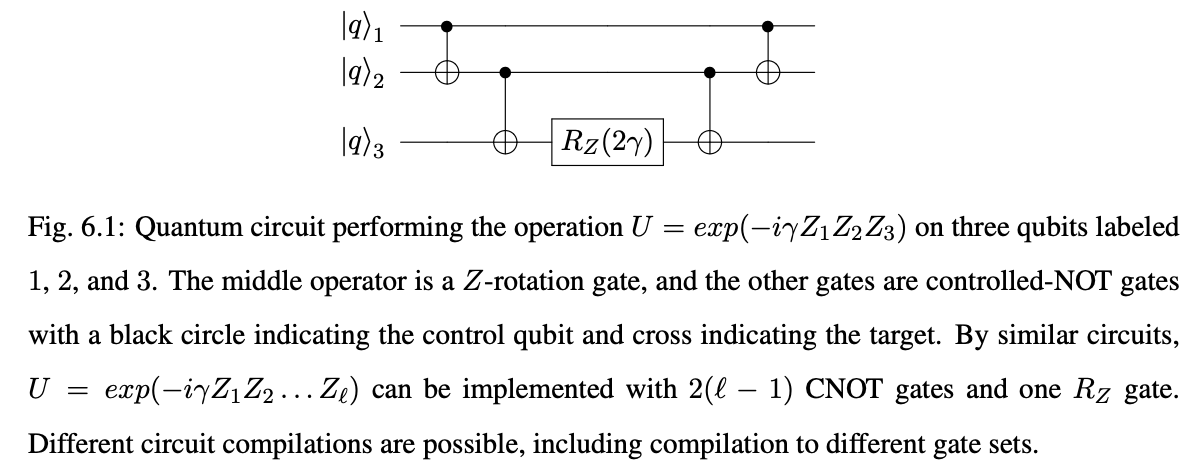

In [486]:
def quad_cost_circ(γ, Q, B):
    """Return a quantum circuit for the quadratic part of the given QUBO 
    specified by the matrix Q. γ is a given QAOA parameter. """
    
    n = len(B)
    circ = QuantumCircuit(n, name='quad_cost')
    
    # Construct the quadratic part
    for i in range(n):
        for j in range(i+1, n):
            circ.cx(i,j)
            phase = 0
            if (i,j) in Q:
                phase += γ * Q[(i,j)]
            if (j,i) in Q:
                phase += γ * Q[(j,i)]       
            if phase != 0:
                circ.rz(2 * phase, j)
            circ.cx(i,j)
        
    return circ

def qaoa_circ(W, w, v, p):
    """Return a parametrized circuit with 2p parameters"""
#     p = int(len(para)/2)
#     γ, β = para[:p], para[p:]
    
    Q, B, _ = get_Q_B(W, w, v)
    
    n = len(B) # number of qubits
    circ = QuantumCircuit(n)

    # The linear phase from Q
    coef = 0
    for i in range(n):
        if (i,i) in Q:
            coef += Q[(i,i)]    
    
    for ind in range(p):
        γ = Parameter(f"γ_{ind}")
        β = Parameter(f"β_{ind}")
        circ = circ + quad_cost_circ(γ, Q, B)
        
        # Construct the linear part, and mixer part 
        for i in range(n):
            phase_z = γ * coef + B[i]
            phase_x = β * pi
            θ, ϕ, λ = phase_x, -pi/2, phase_z-pi/2
            circ.u3(θ, ϕ, λ, i)
        circ.barrier()
        
    circ.measure_all()

    return circ, Q, B


def qaoa(W, w, v, p = 1, backend = Aer.get_backend('qasm_simulator'), shots = 1000, optimizer="nelder-mead"):
    
    circ, Q, B = qaoa_circ(W, w, v, p)
    
    def qaoa_cost(para):
        circ_para = circ.bind_parameters(dict(zip(circ.parameters, para)))
        counts = backend.run(circ_para, shots=shots).result().get_counts()
    
        counts = {k: v/shots for k, v in counts.items()}
        
        cost = 0
        for count, prob in counts.items():
            for ind, val in Q.items():
                if count[ind[0]]=='1' and count[ind[1]]=='1':
                    cost += val * prob

            for ind, val in B.items():
                if count[ind] == '1':
                    cost += val * prob
        
#         print(f"cost={cost}")
        return cost
        
    para0 = np.random.rand(2*p)        
    paras = [para0]
    costs = [qaoa_cost(para0)]
    
    def store(para):
        paras.append(para)
        costs.append(qaoa_cost(para))
        
#     minimize(qaoa_cost, para0, method="CG", callback=store, options={"gtol": 1e-12})
    minimize(qaoa_cost, para0, method=optimizer, callback=store)
    
    circ_para = circ.bind_parameters(dict(zip(circ.parameters, paras[-1])))
    counts = backend.run(circ_para, shots=shots).result().get_counts()
    counts = {tuple([int(kk) for kk in k]): v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}    
    
    sols = post_process(W, w, v, counts)
    
    return circ, paras, costs, sols



In [487]:
circ, paras, costs, sols = qaoa(W, w, v, p=2)

The chosen penalty weight = 90


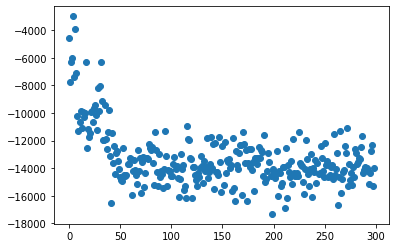

In [488]:
plt.plot(costs, 'o')

In [489]:
sols

{21: {'prob': 0.016000000000000007,
  'conf': {(0, 1, 1, 1, 0), (1, 0, 1, 0, 1)}},
 20: {'prob': 0.02000000000000001, 'conf': {(1, 0, 1, 1, 0), (1, 1, 0, 0, 1)}},
 19: {'prob': 0.008, 'conf': {(1, 1, 0, 1, 0)}},
 18: {'prob': 0.02200000000000001, 'conf': {(1, 1, 1, 0, 0)}},
 17: {'prob': 0.02700000000000001, 'conf': {(0, 0, 0, 1, 1)}},
 16: {'prob': 0.03800000000000002, 'conf': {(0, 0, 1, 0, 1)}},
 15: {'prob': 0.10400000000000004, 'conf': {(0, 0, 1, 1, 0), (0, 1, 0, 0, 1)}},
 14: {'prob': 0.06600000000000003, 'conf': {(0, 1, 0, 1, 0), (1, 0, 0, 0, 1)}},
 13: {'prob': 0.053000000000000026,
  'conf': {(0, 1, 1, 0, 0), (1, 0, 0, 1, 0)}},
 12: {'prob': 0.021000000000000005, 'conf': {(1, 0, 1, 0, 0)}},
 11: {'prob': 0.020000000000000004, 'conf': {(1, 1, 0, 0, 0)}},
 9: {'prob': 0.04600000000000002, 'conf': {(0, 0, 0, 0, 1)}},
 8: {'prob': 0.05500000000000002, 'conf': {(0, 0, 0, 1, 0)}},
 7: {'prob': 0.14500000000000005, 'conf': {(0, 0, 1, 0, 0)}},
 6: {'prob': 0.06600000000000003, 'conf': 

# Method 5: simulated adiabatic quantum computation (sAQC)

Let us summarize the idea of using quantum circuit to simualte adiabatic quantum computation. 

Adiabatic Quantum Computation (AQC) is a different model of quantum computation. It is based on the adiabatic approximation [[1]](#reference):

> For a system initially prepared in an eigenstate (e.g., the ground state) $\left|\epsilon_0(0)\right\rangle$ of a time-dependent Hamiltonian $H(t)$, the time evolution governed by the Schrödinger equation $i\frac{\partial\left|\psi(t)\right\rangle}{\partial t} = H(t)\left|\psi(t)\right\rangle$ (we set $\hbar=1$ from now on) will approximately keep the actual state $\left|\psi(t)\right\rangle$ of the system in the corresponding instantaneous ground state (or other eigenstate) $\left|\epsilon_0(t)\right\rangle$ of $H(t)$, provided that $H(t)$ varies “sufficiently slowly”.


One way to construct the time dependent Hamiltonian $H(t)$ is by interpolation of the initial Hamiltonian $H_0$ and final Hamiltonians $H_f$
\begin{align}
H(t) = \bar{\beta}(t)H_0 + \bar{\gamma}(t) H_f,
\end{align}
where $\bar{\beta}(t)$ and $\bar{\gamma}(t)$ are monotonically decreasing and increasing, respectively, and $\bar{\beta}(0)=1$, $\bar{\beta}(t_f)=0$, $\bar{\gamma}(0)=0$, $\bar{\gamma}(t_f)=1$.

Here, we are interested in using quantum circuit to model AQC. In particular, we shall choose the initial Hamiltonian to be tensor product of Pauli X operators
\begin{align}
H_0=\prod_{i=1}^nX_i
\end{align}
where there are $n$ qubits in the system, and the final Hamiltonian is the Ising Hamiltonian
\begin{align}
H_f=\sum_{i,j}Q_{ij}Z_iZ_{j} + \sum_{i}B_iZ_i
\end{align}

First, let us discretize the time window $[0,t_f]$ into $p$ pieces, and define 
\begin{align}
t_i=i\frac{t_f}{p}, \quad, i=0, ..., p
\end{align}
such that we can approximate the dynamics as governed by $p+1$ time-independent Hamiltonians 
\begin{align}
H_i\equiv H(t_i) = \bar{\beta}(t_i)H_0 + \bar{\gamma}(t_i)H_f 
\end{align}
The evolution operator reads
\begin{align}
U(t_f) \approx \prod_{i=1}^p\exp(-iH_i(t_i-t_{i-1})) = \prod_{i=1}^p\exp\left\{-i\frac{t_f}{p}(\bar{\beta}(t_i)H_0 + \bar{\gamma}(t_i)H_f)\right\}\approx\prod_{i=1}^p\exp\left\{-i\frac{t_f}{p}\bar{\gamma}(t_i)H_f\right\}\exp\left\{-i\frac{t_f}{p}\bar{\beta}(t_i) H_0\right\}
\end{align}
where the approximation in the last line is correct up to $O(1/p^2)$. Thus the AQC is a good approximation for large $p$, as it should be. For the convenience of this benchmark, we further assume that 
\begin{align}
\beta_i\equiv\frac{t_f}{p}\bar{\beta}(t_i)=1-\frac{i}{p}, \quad
\gamma_i\equiv\frac{t_f}{p}\bar{\gamma}(t_i)=\frac{i}{p}
\end{align}
such that
\begin{align}
U(t_f) 
\approx\prod_{i=1}^p\exp\left\{-i\gamma_iH_1\right\}\exp\left\{-i\beta_i H_0\right\} = \prod_{i=1}^pU(H_1, \gamma_i)U(H_0, \beta_i)
\end{align}
which is ready to be implemented on a quantum circuit. In particular, it is clear that the circuit is identical to the one used in QAOA, with the parameter $(\gamma_i, \beta_i)$ given above (Note that there are $2p$ parameters for a given $p$).

The introduction above is from [Lukas](https://github.com/lbotsch/ibm-quantum-challenge-fall-2021/blob/main/solutions-by-participants/challenge-4/4C_LukasBotsch.ipynb).

In [490]:
def sAQC(W, w, v, p=2, shots = 1000):
    circ, _, _ = qaoa_circ(W, w, v, p)

    γ = [(i+1)/p for i in range(p+1)]
    β = [1-(i+1)/p for i in range(p+1)]
    paras = γ + β

    circ_para = circ.bind_parameters(dict(zip(circ.parameters, paras)))

    counts = backend.run(circ_para, shots=shots).result().get_counts()
    counts = {tuple([int(kk) for kk in k]): v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}    

    sols = post_process(W, w, v, counts)

    return sols    

In [491]:
p = 10
shots = 1000
sols = sAQC(W, w, v, p=p, shots = 1000)
sols

The chosen penalty weight = 90


{21: {'prob': 0.07000000000000003, 'conf': {(0, 1, 1, 1, 0), (1, 0, 1, 0, 1)}},
 20: {'prob': 0.06600000000000004, 'conf': {(1, 0, 1, 1, 0), (1, 1, 0, 0, 1)}},
 19: {'prob': 0.02300000000000001, 'conf': {(1, 1, 0, 1, 0)}},
 18: {'prob': 0.02400000000000001, 'conf': {(1, 1, 1, 0, 0)}},
 17: {'prob': 0.03500000000000002, 'conf': {(0, 0, 0, 1, 1)}},
 16: {'prob': 0.03800000000000002, 'conf': {(0, 0, 1, 0, 1)}},
 15: {'prob': 0.07400000000000002, 'conf': {(0, 0, 1, 1, 0), (0, 1, 0, 0, 1)}},
 14: {'prob': 0.06800000000000003, 'conf': {(0, 1, 0, 1, 0), (1, 0, 0, 0, 1)}},
 13: {'prob': 0.06100000000000004, 'conf': {(0, 1, 1, 0, 0), (1, 0, 0, 1, 0)}},
 12: {'prob': 0.02200000000000001, 'conf': {(1, 0, 1, 0, 0)}},
 11: {'prob': 0.04300000000000002, 'conf': {(1, 1, 0, 0, 0)}},
 9: {'prob': 0.030000000000000016, 'conf': {(0, 0, 0, 0, 1)}},
 8: {'prob': 0.02400000000000001, 'conf': {(0, 0, 0, 1, 0)}},
 7: {'prob': 0.03600000000000002, 'conf': {(0, 0, 1, 0, 0)}},
 6: {'prob': 0.029000000000000012, 

In [462]:
circ.draw('mpl')

# Method 6: Simulated adiabatic quantum computation with penalty dephasing

This is an idea from [Knapsack Problem variants of QAOA
for battery revenue optimisation](https://arxiv.org/pdf/1908.02210.pdf). This method is very similar to the sAQC above, in particular the mixing part is identical. The difference is that we separate the full cost function into two parts, the return part and the penalty part. The return part is nothing but the linear term of the full cost function (more generally, it is the cost function without the term with Lagrange multiplier)
\begin{align}
f_\text{return} = -\sum_ix_iv_i
\end{align}
The penalty part is 
\begin{align}
f_\text{penalty} = P(\sum_iw_ix_i + \sum_k2^kc_k - W)^2
\end{align}

The method consists of five steps

1. Encode the return part;
2. Calculate the cost 
3. Constraint testing (marking the indices whose data exceed $C_{max}$)
4. Penalty dephasing (adding penalty to the marked indices)
5. Reinitialization of constraint testing and cost calculation (clean the data register and flag register)

The code belows is from [Lukas](https://github.com/lbotsch/ibm-quantum-challenge-fall-2021/blob/main/solutions-by-participants/challenge-4/4C_LukasBotsch.ipynb).

In [690]:
def phase_return(v, γ):    
    n = len(v)
    circ = QuantumCircuit(n, name="phase_return")
    for i in range(n):
        circ.rz(-2*γ*v[i], i)

    return circ

def qft(data_qubits: int, inverse=False) -> QuantumCircuit:
    """Quantum Fourier Transform (https://arxiv.org/pdf/1411.5949.pdf)"""
    qc = QuantumCircuit(data_qubits)

    N = data_qubits-1

    qc.h(N)
    for n in range(1, N+1):
        qc.cp(2*np.pi / 2**(n+1), N-n, N)

    for i in range(1, N):
        qc.h(N-i)
        for n in range(1, N-i+1):
            qc.cp(2*np.pi / 2**(n+1), N-(n+i), N-i)
    qc.h(0)

    # Calculate IQFT
    qc = qc.inverse() if inverse else qc
    return qc

def qft_add(data_qubits: int, const: int) -> QuantumCircuit:
    """QFT Adder (https://arxiv.org/pdf/1411.5949.pdf)"""

    qc = QuantumCircuit(data_qubits)

    N = data_qubits-1

    bin_const = [int(x) for x in bin(const)[2:]] # Big endian
    bin_const = [0]*(N-len(bin_const)) + bin_const

    for n in range(1, N+1):
        if bin_const[n-1]:
            qc.p(2*np.pi / 2**(n+1), N)

    for i in range(1, N+1):
        for n in range(N-i+1):
            if bin_const[n+i-1]:
                qc.p(2*np.pi / 2**(n+1), N-i)

    return qc


def cost_calculation(z_qubits: int, cost_qubits: int, w: list) -> Union[Gate, QuantumCircuit]:
    """Calculate cost(z)."""
    qr_z = QuantumRegister(z_qubits, "z")
    qr_cost = QuantumRegister(cost_qubits, "cost")
    qc = QuantumCircuit(qr_z, qr_cost, name=" cost_calculation ")

    qc.h(qr_cost)
    for i, c in enumerate(w):
        qc.append(qft_add(cost_qubits, c).control(1), [qr_z[i]] + qr_cost[:])
    
    return qc
#     return qc.to_gate(label=" cost_calculation ") if to_gate else qc


def constraint_testing(cost_qubits: int, C_max: int) -> Union[Gate, QuantumCircuit]:
    """Test the condition cost(z) > C_max and set a flag F if the condition holds
    true.

    """

    qr_cost = QuantumRegister(cost_qubits, "cost")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_cost, qr_f, name=" constraint_testing ")

    c = cost_qubits-1
    w = 2**c - C_max - 1

    if w > 0:
        # Add w to cost(z)
        qc.append(qft(cost_qubits), qr_cost)
        qc.append(qft_add(cost_qubits, w), qr_cost)
        qc.append(qft(cost_qubits, inverse=True), qr_cost)
        # Set F if the condition cost(z) > C_max holds
        qc.cx(qr_cost[c], qr_f)

    return qc
#     return qc.to_gate(label=" constraint_testing ") if to_gate else qc

    
def penalty_dephasing(cost_qubits: int, alpha: float, gamma: float) -> QuantumCircuit:
    """Apply the penalty part of U(C, γ)."""
    
    qr_cost = QuantumRegister(cost_qubits, "cost")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_cost, qr_f, name="penalty_dephasing")

    # Add phase alpha * (cost(z) + w) to all infeasible states
    for i in range(cost_qubits):
        qc.cp((2**i) * alpha * gamma, qr_f, qr_cost[i])

    # Add phase -alpha * (Cmax + w) = -alpha * 2^(cost_qubits-1) to all
    # infeasible states
    C_max_plus_w = 2**(cost_qubits-1)-1
    qc.p(-C_max_plus_w * alpha * gamma, qr_f)

    return qc

def reinitialization(z_qubits: int, cost_qubits: int, w, C_max: int) -> QuantumCircuit:
    """Reinitialize the ancilla qubits to |0>."""
    
    qr_z = QuantumRegister(z_qubits, "z")
    qr_cost = QuantumRegister(cost_qubits, "cost")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_z, qr_cost, qr_f, name="reinitialization")

#     qc.append(constraint_testing(cost_qubits, C_max).inverse().to_gate(label="  Constraint Testing +  "), qr_cost[:] + qr_f[:])
#     qc.append(cost_calculation(z_qubits, cost_qubits, w).inverse().to_gate(label="  Cost Calculation +  "), qr_z[:] + qr_cost[:])
    qc.append(constraint_testing(cost_qubits, C_max).inverse(), qr_cost[:] + qr_f[:])
    qc.append(cost_calculation(z_qubits, cost_qubits, w).inverse(), qr_z[:] + qr_cost[:])

    return qc
    

In [710]:
def sAQC_v2(W, w, v, P = None, p=1, backend = Aer.get_backend('qasm_simulator'), shots = 1000):
    
    # the number of qubits representing answers
    z_qubits = len(v)
    
#     C_diff = [c2-c1 for c1, c2 in zip(C1, C2)]
#     C_max -= sum(C1)
    
#     # the maximum possible total cost
#     max_c = sum(C_diff)
    
    # the number of qubits representing data values can be defined using the maximum possible total cost as follows:
#     cost_qubits = np.ceil(math.log(max_c, 2)) + 1 if not max_c & (max_c - 1) == 0 else math.ceil(math.log(max_c, 2)) + 2
    cost_qubits = int(np.ceil(np.log2(W))) + 1
    
    qr_z = QuantumRegister(z_qubits, "z") # index register
    qr_cost = QuantumRegister(cost_qubits, "cost") # data register
    qr_f = QuantumRegister(1, "flag") # flag register
    cr_z = ClassicalRegister(z_qubits, "c_z") # classical register storing the measurement result of index register
    qc = QuantumCircuit(qr_z, qr_cost, qr_f, cr_z)
    
    ### initialize the index register with uniform superposition state ###
    qc.h(qr_z)
    
    if P is None:
        # The default penalty weight is 10 times the max bias.
        P = 10 * max(max(v), -min(v)) 
        print(f"The chosen penalty weight = {P}")
    
    for i in range(p):
        
        ### set fixed parameters for each round ###
        β = 1 - (i + 1) / p
        γ = (i + 1) / p
        
        ### return part ###
        qc.append(phase_return(v, γ), qr_z)
        
        ### step 1: cost calculation ###
        qc.append(cost_calculation(z_qubits, cost_qubits, w), qr_z[:] + qr_cost[:])
        
        ### step 2: Constraint testing ###
        qc.append(constraint_testing(cost_qubits, W), qr_cost[:] + qr_f[:])
        
        ### step 3: penalty dephasing ###
        qc.append(penalty_dephasing(cost_qubits, P, γ), qr_cost[:] + qr_f[:])
        
        ### step 4: reinitialization ###
        qc.append(reinitialization(z_qubits, cost_qubits, w, W), qr_z[:] + qr_cost[:] + qr_f[:])
        
        ### mixing operator ###
        for j in range(z_qubits):
            qc.rx(β * pi, j)
        qc.barrier()

    ### measure the index ###
    ### since the default measurement outcome is shown in big endian, it is necessary to reverse the classical bits in order to unify the endian ###
    qc.measure(qr_z, cr_z[::-1])
    
    qc_transpile = transpile(qc, backend=backend, seed_transpiler=42, optimization_level=3)

    counts = backend.run(qc_transpile).result().get_counts()
    counts = dict(zip([tuple([int(kk) for kk in k]) for k in counts.keys()], counts.values()))
    
    sols = post_process(W, w, v, counts)
    
    return qc, sols
        

In [711]:
qc, sols = sAQC_v2(W, w, v, P = None, p=1)
qc.draw()

The chosen penalty weight = 90


┌───┐┌───────────────┐┌──────────────────────┐                         »
   z_0: ┤ H ├┤0              ├┤0                     ├─────────────────────────»
        ├───┤│               ││                      │                         »
   z_1: ┤ H ├┤1              ├┤1                     ├─────────────────────────»
        ├───┤│               ││                      │                         »
   z_2: ┤ H ├┤2 phase_return ├┤2                     ├─────────────────────────»
        ├───┤│               ││                      │                         »
   z_3: ┤ H ├┤3              ├┤3                     ├─────────────────────────»
        ├───┤│               ││                      │                         »
   z_4: ┤ H ├┤4              ├┤4                     ├─────────────────────────»
        └───┘└───────────────┘│                      │┌───────────────────────┐»
cost_0: ──────────────────────┤5   cost_calculation  ├┤0                      ├»
                              │                      ││                       │»
cost_1: ──────────────────────┤6                     ├┤1                      ├»
                              │                      ││                       │»
cost_2: ──────────────────────┤7                     ├┤2                      ├»
                              │                      ││                       │»
cost_3: ──────────────────────┤8                     ├┤3  constraint_testing  ├»
                              │                      ││                       │»
cost_4: ──────────────────────┤9                     ├┤4                      ├»
                              │                      ││                       │»
cost_5: ──────────────────────┤10                    ├┤5                      ├»
                              └──────────────────────┘│                       │»
flag_0: ──────────────────────────────────────────────┤6                      ├»
                                                      └───────────────────────┘»
 c_z: 5/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«                              ┌────────────────────┐┌───────┐ ░ ┌─┐         »
«   z_0: ──────────────────────┤0                   ├┤ Rx(0) ├─░─┤M├─────────»
«                              │                    │├───────┤ ░ └╥┘┌─┐      »
«   z_1: ──────────────────────┤1                   ├┤ Rx(0) ├─░──╫─┤M├──────»
«                              │                    │├───────┤ ░  ║ └╥┘┌─┐   »
«   z_2: ──────────────────────┤2                   ├┤ Rx(0) ├─░──╫──╫─┤M├───»
«                              │                    │├───────┤ ░  ║  ║ └╥┘┌─┐»
«   z_3: ──────────────────────┤3                   ├┤ Rx(0) ├─░──╫──╫──╫─┤M├»
«                              │                    │├───────┤ ░  ║  ║  ║ └╥┘»
«   z_4: ──────────────────────┤4                   ├┤ Rx(0) ├─░──╫──╫──╫──╫─»
«        ┌────────────────────┐│                    │└───────┘ ░  ║  ║  ║  ║ »
«cost_0: ┤0                   ├┤5                   ├──────────░──╫──╫──╫──╫─»
«        │                    ││   reinitialization │          ░  ║  ║  ║  ║ »
«cost_1: ┤1                   ├┤6                   ├──────────░──╫──╫──╫──╫─»
«        │                    ││                    │          ░  ║  ║  ║  ║ »
«cost_2: ┤2                   ├┤7                   ├──────────░──╫──╫──╫──╫─»
«        │                    ││                    │          ░  ║  ║  ║  ║ »
«cost_3: ┤3 penalty_dephasing ├┤8                   ├──────────░──╫──╫──╫──╫─»
«        │                    ││                    │          ░  ║  ║  ║  ║ »
«cost_4: ┤4                   ├┤9                   ├──────────░──╫──╫──╫──╫─»
«        │                    ││                    │          ░  ║  ║  ║  ║ »
«cost_5: ┤5                   ├┤10                  ├──────────░──╫──╫──╫──╫─»
«        │                    ││                    │          ░  ║  ║  ║  ║ »
«fla

In [712]:
sols

{21: {'prob': 0.062, 'conf': {(0, 1, 1, 1, 0), (1, 0, 1, 0, 1)}},
 20: {'prob': 0.08199999999999999, 'conf': {(1, 0, 1, 1, 0), (1, 1, 0, 0, 1)}},
 19: {'prob': 0.027, 'conf': {(1, 1, 0, 1, 0)}},
 18: {'prob': 0.033, 'conf': {(1, 1, 1, 0, 0)}},
 17: {'prob': 0.03, 'conf': {(0, 0, 0, 1, 1)}},
 16: {'prob': 0.043, 'conf': {(0, 0, 1, 0, 1)}},
 15: {'prob': 0.059, 'conf': {(0, 0, 1, 1, 0), (0, 1, 0, 0, 1)}},
 14: {'prob': 0.052000000000000005,
  'conf': {(0, 1, 0, 1, 0), (1, 0, 0, 0, 1)}},
 13: {'prob': 0.061, 'conf': {(0, 1, 1, 0, 0), (1, 0, 0, 1, 0)}},
 12: {'prob': 0.035, 'conf': {(1, 0, 1, 0, 0)}},
 11: {'prob': 0.036, 'conf': {(1, 1, 0, 0, 0)}},
 9: {'prob': 0.034, 'conf': {(0, 0, 0, 0, 1)}},
 8: {'prob': 0.034, 'conf': {(0, 0, 0, 1, 0)}},
 7: {'prob': 0.035, 'conf': {(0, 0, 1, 0, 0)}},
 6: {'prob': 0.025, 'conf': {(0, 1, 0, 0, 0)}},
 5: {'prob': 0.036, 'conf': {(1, 0, 0, 0, 0)}},
 0: {'prob': 0.038, 'conf': {(0, 0, 0, 0, 0)}}}

# Method 7: Simulated adiabatic quantum computation with zeno

In [713]:
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.rz(Parameter('γ'), 1)
qc.cx(0,1)

/Users/MaoLin/psi4conda/envs/py38/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


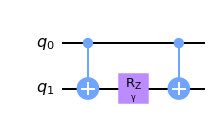

In [714]:
qc.draw('mpl')

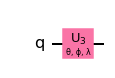

In [718]:
qc = QuantumCircuit(1)
qc.u3(Parameter('θ'), Parameter('ϕ'), Parameter('λ'), 0)
qc.draw('mpl')

In [725]:
qr = QuantumRegister(3)
qc = QuantumCircuit(qr)

for p in range(2):

    qc.append(QuantumCircuit(3, name=f"U(H_{1}, γ_{p+1})"), qr)
    qc.append(QuantumCircuit(3, name=f"U(H_{0}, β_{p+1})"), qr)  
    
    

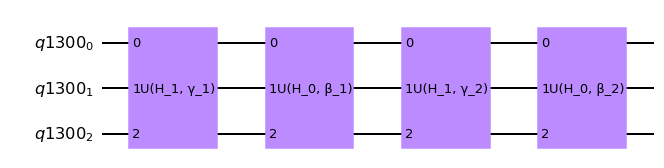

In [726]:
qc.draw('mpl')